# Imports

In [1]:
!pip install tqdm
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, AdditiveAttention, Concatenate, TimeDistributed, Layer, RepeatVector
from keras.models import Model

# Preparing Data

In [47]:
def prepare_data(data_path, batch_size, num_samples):
  with tf.device('/device:GPU:0'):  
    input_texts = []
    target_texts = []
    input_characters = set()
    target_characters = set()
    with open(data_path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
        print()
    for line in lines[: min(num_samples, len(lines) - 1)]:
        target_text, input_text, _ = line.split("\t")
        # We use "tab" as the "start sequence" character
        # for the targets, and "\n" as "end sequence" character.
        target_text = "\t" + target_text.strip("\t\n ") + "\n"
        input_texts.append(input_text.strip("\t\n "))
        target_texts.append(target_text)
        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)

    input_characters = sorted(list(input_characters)+[' '])
    target_characters = sorted(list(target_characters)+[' '])
    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input_texts])
    max_decoder_seq_length = max([len(txt) for txt in target_texts])

    # print("Number of samples:", len(input_texts))
    # print("Number of unique input tokens:", num_encoder_tokens)
    # print("Number of unique output tokens:", num_decoder_tokens)
    # print("Max sequence length for inputs:", max_encoder_seq_length)
    # print("Max sequence length for outputs:", max_decoder_seq_length)

    input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t] = input_token_index[char]
        encoder_input_data[i, t+1:] = input_token_index[' ']

        for t, char in enumerate(target_text):
            decoder_input_data[i, t] = target_token_index[char]
        decoder_input_data[i, t+1:] = input_token_index[' ']

        for t, char in enumerate(target_text):        
            if t > 0:
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        decoder_target_data[i, t:, target_token_index[" "]] = 1.0

    return input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens,num_decoder_tokens,\
          max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index
              

# Question 1

## Building the Model

In [ ]:
def build_model(encoder_input_size, decoder_input_size, embedding_size, latent_dim, hidden_layers, input_vocab, target_vocab, dropout, rec_dropout, cell_type='LSTM'):
  with tf.device('/device:GPU:0'):  
    # Encoder Inputs
    encoder_inputs = Input(shape=(encoder_input_size))
    encoder_embeddings = Embedding(input_vocab, embedding_size)(encoder_inputs)
    #Decoder Inputs
    decoder_inputs = Input(shape=(decoder_input_size))
    decoder_embeddings = Embedding(target_vocab, embedding_size)(decoder_inputs)

    if cell_type == 'RNN':
      # Encoder    
      encoder_RNNs = [SimpleRNN(latent_dim, dropout= dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True) for _ in range(hidden_layers)]
      encoder_states = []
      encoder_output, state_h = encoder_RNNs[0](encoder_embeddings)
      encoder_states.extend([state_h])
      for i in range(1, hidden_layers):
        encoder_output, state_h_e = encoder_RNNs[i](encoder_output)
        encoder_states.append(state_h_e)

      # Decoder    
      decoder_RNNs, decoder_states = [], []
      decoder_RNNs.append(SimpleRNN(latent_dim, dropout= dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True))
      decoder_output, state_h = decoder_RNNs[0](decoder_embeddings, initial_state=encoder_states[0])
      decoder_states.append(state_h)
      for i in range(1, hidden_layers):
        decoder_RNNs.append(SimpleRNN(latent_dim, dropout= dropout, recurrent_dropout=rec_dropout, return_sequences=True, return_state=True))
        decoder_output, state_h_d = decoder_RNNs[i](decoder_output, initial_state=encoder_states[i])
        decoder_states.append(state_h_d)

      decoder_dense = keras.layers.Dense(target_vocab, activation="softmax")
      decoder_output = decoder_dense(decoder_output)
      model = Model([encoder_inputs, decoder_inputs], decoder_output)

      # Encoder (Inference)
      encoder_states_i = []
      encoder_output_i, state_h_i = encoder_RNNs[0](encoder_embeddings)
      encoder_states_i.append(state_h_i)
      for i in range(1, hidden_layers):
        encoder_output_i, state_h_e, state_c_e = encoder_RNNs[i](encoder_output_i)
        encoder_states_i.append(state_h_e)
      encoder_model = Model(encoder_inputs, encoder_states_i)

      # Decoder (Inference)
      decoder_states_inputs = [keras.Input(shape=(latent_dim)) for _ in range(hidden_layers)]
      decoder_states_i = []
      decoder_output_i, state_h_d_i = decoder_RNNs[0](decoder_embeddings, initial_state=decoder_states_inputs[0])
      decoder_states_i.append(state_h_d_i)
      for i in range(1, hidden_layers):
        decoder_output_i, state_h_d_i = decoder_RNNs[i](decoder_output_i, initial_state=decoder_states_inputs[i])
        decoder_states_i.append(state_h_d_i)

      decoder_output_i = decoder_dense(decoder_output_i)
      decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_output_i] + decoder_states_i)

    elif cell_type == 'GRU':
      # Encoder    
      encoder_GRUs = [GRU(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True) for _ in range(hidden_layers)]
      encoder_states = []
      encoder_output, state_h = encoder_GRUs[0](encoder_embeddings)
      encoder_states.extend([state_h])
      for i in range(1, hidden_layers):
        encoder_output, state_h_e = encoder_GRUs[i](encoder_output)
        encoder_states.append(state_h_e)

      # Decoder    
      decoder_GRUs, decoder_states = [], []
      decoder_GRUs.append(GRU(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True))
      decoder_output, state_h = decoder_GRUs[0](decoder_embeddings, initial_state=encoder_states[0])
      decoder_states.append(state_h)
      for i in range(1, hidden_layers):
        decoder_GRUs.append(GRU(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_sequences=True, return_state=True))
        decoder_output, state_h_d = decoder_GRUs[i](decoder_output, initial_state=encoder_states[i])
        decoder_states.append(state_h_d)

      decoder_dense = keras.layers.Dense(target_vocab, activation="softmax")
      decoder_output = decoder_dense(decoder_output)
      model = Model([encoder_inputs, decoder_inputs], decoder_output)

      # Encoder (Inference)
      encoder_states_i = []
      encoder_output_i, state_h_i = encoder_GRUs[0](encoder_embeddings)
      encoder_states_i.append(state_h_i)
      for i in range(1, hidden_layers):
        encoder_output_i, state_h_e = encoder_GRUs[i](encoder_output_i)
        encoder_states_i.append(state_h_e)
      encoder_model = Model(encoder_inputs, encoder_states_i)

      # Decoder (Inference)
      decoder_states_inputs = [keras.Input(shape=(latent_dim)) for _ in range(hidden_layers)]
      decoder_states_i = []
      decoder_output_i, state_h_d_i = decoder_GRUs[0](decoder_embeddings, initial_state=decoder_states_inputs[0])
      decoder_states_i.append(state_h_d_i)
      for i in range(1, hidden_layers):
        decoder_output_i, state_h_d_i = decoder_GRUs[i](decoder_output_i, initial_state=decoder_states_inputs[i])
        decoder_states_i.append(state_h_d_i)

      decoder_output_i = decoder_dense(decoder_output_i)
      decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_output_i] + decoder_states_i)

    else:
      # Encoder
      encoder_inputs = Input(shape=(encoder_input_size))
      encoder_embeddings = Embedding(input_vocab, embedding_size)(encoder_inputs)
      encoder_LSTMs = [LSTM(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True) for _ in range(hidden_layers)]
      encoder_states = []
      encoder_output, state_h, state_c = encoder_LSTMs[0](encoder_embeddings)
      encoder_states.extend([state_h, state_c])
      for i in range(1, hidden_layers):
        encoder_output, state_h_e, state_c_e = encoder_LSTMs[i](encoder_output)
        encoder_states.extend([state_h_e, state_c_e])

      # Decoder
      decoder_LSTMs, decoder_states = [], []
      decoder_LSTMs.append(LSTM(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True))
      decoder_output, state_h, state_c = decoder_LSTMs[0](decoder_embeddings, initial_state=encoder_states[:2])
      decoder_states.extend([state_h, state_c])
      for i in range(1, hidden_layers):
        decoder_LSTMs.append(LSTM(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_sequences=True, return_state=True))
        decoder_output, state_h_d, state_c_d = decoder_LSTMs[i](decoder_output, initial_state=encoder_states[2*i:][:2])
        decoder_states.extend([state_h_d, state_c_d])

      decoder_dense = keras.layers.Dense(target_vocab, activation="softmax")
      decoder_output = decoder_dense(decoder_output)
      model = Model([encoder_inputs, decoder_inputs], decoder_output)

      # Encoder (Inference)
      encoder_states_i = []
      encoder_output_i, state_h_i, state_c_i = encoder_LSTMs[0](encoder_embeddings)
      encoder_states_i.extend([state_h_i, state_c_i])
      for i in range(1, hidden_layers):
        encoder_output_i, state_h_e, state_c_e = encoder_LSTMs[i](encoder_output_i)
        encoder_states_i.extend([state_h_e, state_c_e])
      encoder_model = Model(encoder_inputs, encoder_states_i)

      # Decoder (Inference)
      decoder_states_inputs = [keras.Input(shape=(latent_dim)) for _ in range(2*hidden_layers)]
      decoder_states_i = []
      decoder_output_i, state_h_d_i, state_c_d_i = decoder_LSTMs[0](decoder_embeddings, initial_state=decoder_states_inputs[:2])
      decoder_states_i.extend([state_h_d_i, state_c_d_i])
      for i in range(1, hidden_layers):
        decoder_output_i, state_h_d_i, state_c_d_i = decoder_LSTMs[i](decoder_output_i, initial_state=decoder_states_inputs[2*i:][:2])
        decoder_states_i.extend([state_h_d_i, state_c_d_i])

      decoder_output_i = decoder_dense(decoder_output_i)
      decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_output_i] + decoder_states_i)

    return model, encoder_model, decoder_model

In [ ]:
input_texts, target_text, encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens,num_decoder_tokens,\
 max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index = prepare_data(data_path, batch_size, num_samples)

model, encoder_model, decoder_model= build_model(max_encoder_seq_length, max_decoder_seq_length, embedding_size,
                                                 latent_dim, num_encoder_tokens, num_decoder_tokens, cell_type= 'LSTM') 
model.summary()

## Training the Model

In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

## Using the Model

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        decoder_output = decoder_model.predict([target_seq] + [states_value])
        # print(decoder_output)
        output_tokens, states = decoder_output[0], decoder_output[1:]
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        # target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [states]
    return decoded_sentence    

In [ ]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

# Question 2

## Wandb Integration

In [ ]:
!pip install --upgrade wandb

In [ ]:
!wandb login dd888f73500a67fc53f9191092b22f3946ac0e02

In [ ]:
# Init wandb
import wandb
from wandb.keras import WandbCallback

wandb.init(project="assignment-3", entity="ravi-kumar")

## Wandb Configuration

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'cell_type' : {
            'values': ['RNN', 'GRU', 'LSTM']
        },
        'embedding_size':{
            'values': [32, 64, 128, 256]
        },
        'hidden_layers' :{
            'values': [1, 2, 3]
        },
        'hidden_layer_size' :{
            'values': [32, 64, 128, 256]
        },
        'dropout' :{
            'values': [0.2, 0.3]
        },
        'batch_size' : {
            'values': [64, 128, 256]
        },
        'epochs':{
            'values': [10, 20]
        }
    }
}

## Running Wandb Sweeps

In [ ]:
def train():
  with tf.device('/device:GPU:0'):    
    # Wandb Configuration
    config_defaults = {
        'cell_type' : 'RNN',
        'embedding_size': 128,
        'hidden_layers' : 1,
        'hidden_layer_size' : 128,
        'dropout' : 0.3,
        'rec_dropout' : 0.2,
        'batch_size' : 64,
        'epochs': 10
    }
    wandb.init(config=config_defaults)
    config= wandb.config

    # Parameters
    batch_size = config.batch_size
    epochs = config.epochs
    latent_dim = config.hidden_layer_size
    embedding_size = config.embedding_size
    hidden_layers = config.hidden_layers
    cell_type = config.cell_type
    dropout = config.dropout
    rec_dropout = 0 #config.rec_dropout
    num_samples = 44205
    # Path to the data txt file on disk.
    data_path = "/content/drive/MyDrive/Deep Learning/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"

    # Preparing/Loading Data
    input_texts, target_text, encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens,num_decoder_tokens,\
    max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index = prepare_data(data_path, batch_size, num_samples)

    # Building Model
    model, encoder_model, decoder_model= build_model(max_encoder_seq_length, max_decoder_seq_length, embedding_size,
                                                 latent_dim, hidden_layers, num_encoder_tokens, num_decoder_tokens, dropout, rec_dropout, cell_type= cell_type) 
    
    # Training Model
    model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[WandbCallback()]
    )

In [5]:
sweep_id = wandb.sweep(sweep_config, entity="ravi-kumar", project="assignment-3")

Create sweep with ID: d71k4yrm
Sweep URL: https://wandb.ai/ravi-kumar/assignment-3/sweeps/d71k4yrm


In [ ]:
wandb.agent(sweep_id, train)

# Question 4

## Building the Model

In [10]:
def build_model(encoder_input_size, decoder_input_size, embedding_size, latent_dim, hidden_layers, input_vocab, target_vocab, dropout, rec_dropout, cell_type='LSTM'):
  with tf.device('/device:GPU:0'):  
    # Encoder Inputs
    encoder_inputs = Input(shape=(encoder_input_size))
    encoder_embeddings = Embedding(input_vocab, embedding_size)(encoder_inputs)
    #Decoder Inputs
    decoder_inputs = Input(shape=(decoder_input_size))
    decoder_embeddings = Embedding(target_vocab, embedding_size)(decoder_inputs)

    if cell_type == 'RNN':
      # Encoder    
      encoder_RNNs = [SimpleRNN(latent_dim, dropout= dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True) for _ in range(hidden_layers)]
      encoder_states = []
      encoder_output, state_h = encoder_RNNs[0](encoder_embeddings)
      encoder_states.extend([state_h])
      for i in range(1, hidden_layers):
        encoder_output, state_h_e = encoder_RNNs[i](encoder_output)
        encoder_states.append(state_h_e)

      # Decoder    
      decoder_RNNs, decoder_states = [], []
      decoder_RNNs.append(SimpleRNN(latent_dim, dropout= dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True))
      decoder_output, state_h = decoder_RNNs[0](decoder_embeddings, initial_state=encoder_states[0])
      decoder_states.append(state_h)
      for i in range(1, hidden_layers):
        decoder_RNNs.append(SimpleRNN(latent_dim, dropout= dropout, recurrent_dropout=rec_dropout, return_sequences=True, return_state=True))
        decoder_output, state_h_d = decoder_RNNs[i](decoder_output, initial_state=encoder_states[i])
        decoder_states.append(state_h_d)

      decoder_dense = keras.layers.Dense(target_vocab, activation="softmax")
      decoder_output = decoder_dense(decoder_output)
      model = Model([encoder_inputs, decoder_inputs], decoder_output)

      # Encoder (Inference)
      encoder_states_i = []
      encoder_output_i, state_h_i = encoder_RNNs[0](encoder_embeddings)
      encoder_states_i.append(state_h_i)
      for i in range(1, hidden_layers):
        encoder_output_i, state_h_e, state_c_e = encoder_RNNs[i](encoder_output_i)
        encoder_states_i.append(state_h_e)
      encoder_model = Model(encoder_inputs, encoder_states_i)

      # Decoder (Inference)
      decoder_states_inputs = [keras.Input(shape=(latent_dim)) for _ in range(hidden_layers)]
      decoder_states_i = []
      decoder_output_i, state_h_d_i = decoder_RNNs[0](decoder_embeddings, initial_state=decoder_states_inputs[0])
      decoder_states_i.append(state_h_d_i)
      for i in range(1, hidden_layers):
        decoder_output_i, state_h_d_i = decoder_RNNs[i](decoder_output_i, initial_state=decoder_states_inputs[i])
        decoder_states_i.append(state_h_d_i)

      decoder_output_i = decoder_dense(decoder_output_i)
      decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_output_i] + decoder_states_i)

    elif cell_type == 'GRU':
      # Encoder    
      encoder_GRUs = [GRU(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True) for _ in range(hidden_layers)]
      encoder_states = []
      encoder_output, state_h = encoder_GRUs[0](encoder_embeddings)
      encoder_states.extend([state_h])
      for i in range(1, hidden_layers):
        encoder_output, state_h_e = encoder_GRUs[i](encoder_output)
        encoder_states.append(state_h_e)

      # Decoder    
      decoder_GRUs, decoder_states = [], []
      decoder_GRUs.append(GRU(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True))
      decoder_output, state_h = decoder_GRUs[0](decoder_embeddings, initial_state=encoder_states[0])
      decoder_states.append(state_h)
      for i in range(1, hidden_layers):
        decoder_GRUs.append(GRU(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_sequences=True, return_state=True))
        decoder_output, state_h_d = decoder_GRUs[i](decoder_output, initial_state=encoder_states[i])
        decoder_states.append(state_h_d)

      decoder_dense = keras.layers.Dense(target_vocab, activation="softmax")
      decoder_output = decoder_dense(decoder_output)
      model = Model([encoder_inputs, decoder_inputs], decoder_output)

      # Encoder (Inference)
      encoder_states_i = []
      encoder_output_i, state_h_i = encoder_GRUs[0](encoder_embeddings)
      encoder_states_i.append(state_h_i)
      for i in range(1, hidden_layers):
        encoder_output_i, state_h_e = encoder_GRUs[i](encoder_output_i)
        encoder_states_i.append(state_h_e)
      encoder_model = Model(encoder_inputs, encoder_states_i)

      # Decoder (Inference)
      decoder_states_inputs = [keras.Input(shape=(latent_dim)) for _ in range(hidden_layers)]
      decoder_states_i = []
      decoder_output_i, state_h_d_i = decoder_GRUs[0](decoder_embeddings, initial_state=decoder_states_inputs[0])
      decoder_states_i.append(state_h_d_i)
      for i in range(1, hidden_layers):
        decoder_output_i, state_h_d_i = decoder_GRUs[i](decoder_output_i, initial_state=decoder_states_inputs[i])
        decoder_states_i.append(state_h_d_i)

      decoder_output_i = decoder_dense(decoder_output_i)
      decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_output_i] + decoder_states_i)

    else:
      # Encoder
      encoder_inputs = Input(shape=(encoder_input_size))
      encoder_embeddings = Embedding(input_vocab, embedding_size)(encoder_inputs)
      encoder_LSTMs = [LSTM(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True) for _ in range(hidden_layers)]
      encoder_states = []
      encoder_output, state_h, state_c = encoder_LSTMs[0](encoder_embeddings)
      encoder_states.extend([state_h, state_c])
      for i in range(1, hidden_layers):
        encoder_output, state_h_e, state_c_e = encoder_LSTMs[i](encoder_output)
        encoder_states.extend([state_h_e, state_c_e])

      # Decoder
      decoder_LSTMs, decoder_states = [], []
      decoder_LSTMs.append(LSTM(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_state=True, return_sequences=True))
      decoder_output, state_h, state_c = decoder_LSTMs[0](decoder_embeddings, initial_state=encoder_states[:2])
      decoder_states.extend([state_h, state_c])
      for i in range(1, hidden_layers):
        decoder_LSTMs.append(LSTM(latent_dim, dropout=dropout, recurrent_dropout=rec_dropout, return_sequences=True, return_state=True))
        decoder_output, state_h_d, state_c_d = decoder_LSTMs[i](decoder_output, initial_state=encoder_states[2*i:][:2])
        decoder_states.extend([state_h_d, state_c_d])

      decoder_dense = keras.layers.Dense(target_vocab, activation="softmax")
      decoder_output = decoder_dense(decoder_output)
      model = Model([encoder_inputs, decoder_inputs], decoder_output)

      # Encoder (Inference)
      encoder_states_i = []
      encoder_output_i, state_h_i, state_c_i = encoder_LSTMs[0](encoder_embeddings)
      encoder_states_i.extend([state_h_i, state_c_i])
      for i in range(1, hidden_layers):
        encoder_output_i, state_h_e, state_c_e = encoder_LSTMs[i](encoder_output_i)
        encoder_states_i.extend([state_h_e, state_c_e])
      encoder_model = Model(encoder_inputs, encoder_states_i)

      # Decoder (Inference)
      decoder_states_inputs = [keras.Input(shape=(latent_dim)) for _ in range(2*hidden_layers)]
      decoder_states_i = []
      decoder_output_i, state_h_d_i, state_c_d_i = decoder_LSTMs[0](decoder_embeddings, initial_state=decoder_states_inputs[:2])
      decoder_states_i.extend([state_h_d_i, state_c_d_i])
      for i in range(1, hidden_layers):
        decoder_output_i, state_h_d_i, state_c_d_i = decoder_LSTMs[i](decoder_output_i, initial_state=decoder_states_inputs[2*i:][:2])
        decoder_states_i.extend([state_h_d_i, state_c_d_i])

      decoder_output_i = decoder_dense(decoder_output_i)
      decoder_model = keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_output_i] + decoder_states_i)

    return model, encoder_model, decoder_model

## Testing the Model

### Preparing Test Data

In [ ]:
def prepare_test_data(data_path, batch_size, num_samples, input_token_index, target_token_index):
  with tf.device('/device:GPU:0'):  
    input_texts, target_texts, targets = [], [], []
    
    with open(data_path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    for line in lines[: min(num_samples, len(lines) - 1)]:
        target_text, input_text, _ = line.split("\t")
        # We use "tab" as the "start sequence" character
        # for the targets, and "\n" as "end sequence" character.
        targets.append(target_text.strip("\t\n "))
        target_text = "\t" + target_text.strip("\t\n ") + "\n"
        input_texts.append(input_text.strip("\t\n "))
        target_texts.append(target_text)

    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t] = input_token_index[char]
        encoder_input_data[i, t+1:] = input_token_index[' ']          

        for t, char in enumerate(target_text):
            decoder_input_data[i, t] = target_token_index[char]
        decoder_input_data[i, t+1:] = target_token_index[' ']          

        for t, char in enumerate(target_text):        
            if t > 0:
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        decoder_target_data[i, t:, target_token_index[" "]] = 1.0

    return input_texts, targets, encoder_input_data, decoder_input_data, decoder_target_data
              

### Training the Model with best Configuration

In [ ]:
with tf.device('/device:GPU:0'):
  # Parameters
  batch_size = 64
  epochs = 150
  latent_dim = 64  # hidden layer size
  embedding_size = 256
  hidden_layers = 2
  cell_type = 'LSTM'
  dropout = 0.3
  rec_dropout = 0
  num_samples = 44205

  # Path to the data txt file on disk.
  train_data_path = "/content/drive/MyDrive/Deep Learning/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
  test_data_path = "/content/drive/MyDrive/Deep Learning/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

  # Preparing/Loading Data
  input_texts, target_text, encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens, num_decoder_tokens,\
        max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index = prepare_data(train_data_path, batch_size, num_samples)

  # Building Model
  model, encoder_model, decoder_model = build_model(max_encoder_seq_length, max_decoder_seq_length, embedding_size,
                                                      latent_dim, hidden_layers, num_encoder_tokens, num_decoder_tokens, dropout, rec_dropout, cell_type=cell_type)

  # Training Model
  model.compile(
      optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
  )
  model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.2,
      # callbacks=[EarlyStopping(monitor='val_loss')]
  )


Epoch 1/150
553/553 [==============================] - 14s 16ms/step - loss: 1.2822 - accuracy: 0.7025 - val_loss: 1.0930 - val_accuracy: 0.7254
Epoch 2/150
553/553 [==============================] - 8s 14ms/step - loss: 0.8603 - accuracy: 0.7656 - val_loss: 1.0381 - val_accuracy: 0.7502
Epoch 3/150
553/553 [==============================] - 8s 14ms/step - loss: 0.7140 - accuracy: 0.8005 - val_loss: 0.9094 - val_accuracy: 0.7712
Epoch 4/150
553/553 [==============================] - 8s 14ms/step - loss: 0.5846 - accuracy: 0.8311 - val_loss: 0.8130 - val_accuracy: 0.7895
Epoch 5/150
553/553 [==============================] - 8s 14ms/step - loss: 0.4928 - accuracy: 0.8533 - val_loss: 0.7109 - val_accuracy: 0.8066
Epoch 6/150
553/553 [==============================] - 8s 15ms/step - loss: 0.4171 - accuracy: 0.8733 - val_loss: 0.6726 - val_accuracy: 0.8183
Epoch 7/150
553/553 [==============================] - 8s 15ms/step - loss: 0.3621 - accuracy: 0.8886 - val_loss: 0.5898 - val_accurac

## Evaluating Model

In [11]:
def decode_sequence(input_seq, encoder_model, decoder_model, reverse_target_char_index):
  with tf.device('/device:GPU:0'):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        decoder_output = decoder_model.predict([target_seq] + [states_value])
        # print(decoder_output)
        output_tokens, states = decoder_output[0], decoder_output[1:]
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        # target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [states]
    return decoded_sentence    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 128)      3456        input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 21, 128)      8448        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
def evaluate(data_path, encoder_model, decoder_model, batch_size, input_token_index, target_token_index):
  with tf.device('/device:GPU:0'):
    num_samples = 10000
    # Preparing/Loading Test Data
    input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data = \
    prepare_test_data(data_path, batch_size, num_samples, input_token_index, target_token_index)
    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
    output_path = '/content/drive/MyDrive/Deep Learning/Output/eng-hi.txt'
    correct_predictions = 0
    with open(output_path, "a", encoding="utf-8") as f:
      for seq_index in tqdm(range(encoder_input_data.shape[0]), unit='Words', desc='Words Decoded'):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        # print(input_texts[seq_index],target_texts[seq_index])
        input_seq = encoder_input_data[seq_index : seq_index + 1]
        decoded_word = decode_sequence(input_seq, encoder_model, decoder_model, reverse_target_char_index).strip("\t\n ")
        f.write(input_texts[seq_index]+'\t'+decoded_word+'\n')
        # print('<',decoded_word,'><',target_texts[seq_index],'>')
        if decoded_word==target_texts[seq_index]:
          correct_predictions+=1
        # print("-")
        # print("Input sentence:", input_texts[seq_index])
        # print("Decoded sentence:", decoded_word)
      accuracy = correct_predictions/(seq_index+1)
      print('Accuracy : ', accuracy,'\tCorrect Predictions : ',correct_predictions,'/',(seq_index+1))

In [ ]:
evaluate(test_data_path, encoder_model, decoder_model, batch_size, input_token_index, target_token_index)


Accuracy :  0.2929808973789427 	Correct Predictions :  1319 / 4502


# Question 5

## Attention Layer

In [11]:
class Attention(Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.U = Dense(units)
    self.W = Dense(units)
    self.V = Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.U(query_with_time_axis) + self.W(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## Preparing Data

In [4]:
def prepare_test_data(data_path, batch_size, num_samples, input_token_index, target_token_index):
  with tf.device('/device:GPU:0'):  
    input_texts, target_texts, targets = [], [], []
    
    with open(data_path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    for line in lines[: min(num_samples, len(lines) - 1)]:
        target_text, input_text, _ = line.split("\t")
        # We use "tab" as the "start sequence" character
        # for the targets, and "\n" as "end sequence" character.
        targets.append(target_text.strip("\t\n "))
        target_text = "\t" + target_text.strip("\t\n ") + "\n"
        input_texts.append(input_text.strip("\t\n "))
        target_texts.append(target_text)

    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t] = input_token_index[char]
        encoder_input_data[i, t+1:] = input_token_index[' ']          

        for t, char in enumerate(target_text):
            decoder_input_data[i, t] = target_token_index[char]
        decoder_input_data[i, t+1:] = target_token_index[' ']          

        for t, char in enumerate(target_text):        
            if t > 0:
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        decoder_target_data[i, t:, target_token_index[" "]] = 1.0

    return input_texts, targets, encoder_input_data, decoder_input_data, decoder_target_data
              

 ## Building the Model

In [27]:
def build_model(encoder_input_size, decoder_input_size, embedding_size, latent_dim, input_vocab, target_vocab, dropout=0.2, cell_type='LSTM', pay_attention=False):
  encoder_inputs = Input(shape=(encoder_input_size))
  decoder_inputs = Input(shape=(decoder_input_size))
  encoder_outputs_i = Input(shape=(latent_dim))
  decoder_concat = Concatenate()
  
  model, encoder_model, decoder_model = None, None, None

  if cell_type =='RNN':
    # Encoder
    outputs, state_h = SimpleRNN(latent_dim, dropout=dropout, return_state=True)(encoder_inputs)
    # Decoder
    decoder_RNN = SimpleRNN(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_RNN(decoder_inputs, initial_state=state_h)
    decoder_dense = TimeDistributed(Dense(dencoder_input_size, activation="softmax"))
    # Attention
    attention = AdditiveAttention(name='attention')    
    context_vector, att_weights = attention([decoder_outputs, encoder_outputs], return_attention_scores=True)
    decoder_outputs = decoder_concat([decoder_outputs, context_vector])
    decoder_outputs = decoder_dense(decoder_outputs)
    model= Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # Encoder (Inference)
    encoder_model= Model(encoder_inputs, [outputs, state_h])
    # Decoder (Inference)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_outputs_i, state_h_i = decoder_RNN(decoder_inputs, initial_state=decoder_state_input_h)
    # Attention
    context_vector_i, att_weights_i = attention([decoder_outputs_i, encoder_outputs_i], return_attention_scores=True)
    decoder_outputs_i = decoder_concat([decoder_outputs_i, context_vector_i])
    decoder_outputs_i= decoder_dense(decoder_outputs_i)
    decoder_model= Model([decoder_inputs, state_h_i, encoder_outputs_i], [decoder_outputs_i, att_weights_i, state_h_i])
    
  elif cell_type == 'GRU':
    # Encoder
    encoder_outputs, state_h = GRU(latent_dim, dropout=dropout, return_state=True)(encoder_inputs)
    encoder_state = [state_h]
    # Decoder
    decoder_GRU = GRU(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_GRU(decoder_inputs, initial_state=encoder_state)
    decoder_dense = TimeDistributed(Dense(dencoder_input_size, activation="softmax"))
    # Attention
    attention = AdditiveAttention(name='attention')    
    context_vector, att_weights = attention([decoder_outputs, encoder_outputs], return_attention_scores=True)
    decoder_outputs = decoder_concat([decoder_outputs, context_vector])
    decoder_outputs = decoder_dense(decoder_outputs)
    model= Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # Encoder (Inference)
    encoder_model= keras.models.Model(encoder_inputs, [encoder_outputs, encoder_state])
    # Decoder (Inference)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_outputs_i, state_h_i = decoder_GRU(decoder_inputs, initial_state=decoder_state_input_h)
    # Attention
    context_vector_i, att_weights_i = attention([decoder_outputs_i, encoder_outputs_i], return_attention_scores=True)
    decoder_outputs_i = decoder_concat([decoder_outputs_i, context_vector_i])
    decoder_outputs_i= decoder_dense(decoder_outputs_i)
    decoder_model= Model([decoder_inputs, decoder_state_input_h, encoder_outputs_i], [decoder_outputs_i, att_weights_i, state_h_i])

  else:
    # Encoder
    encoder_embeddings = Embedding(input_vocab, embedding_size)(encoder_inputs)
    encoder_outputs, state_h, state_c = LSTM(latent_dim, dropout=dropout, return_state=True)(encoder_embeddings)
    encoder_states = [state_h, state_c]
    # Decoder
    decoder_embeddings = Embedding(target_vocab, embedding_size)(decoder_inputs)
    decoder_LSTM = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
    decoder_outputs, state_h_d, state_c_d = decoder_LSTM(decoder_embeddings, initial_state=encoder_states)
    # Attention
    # attention = AdditiveAttention(name='attention') 
    attention = Attention(latent_dim)    
    repeat_vector = RepeatVector(decoder_input_size)
    # context_vector, att_weights = attention([decoder_outputs, encoder_outputs], return_attention_scores=True, training=True)
    context_vector, att_weights = attention(encoder_outputs, decoder_outputs)    
    context_vector = repeat_vector(context_vector)
    decoder_outputs = decoder_concat([decoder_outputs, context_vector])
    decoder_dense = TimeDistributed(Dense(target_vocab, activation="softmax"))
    decoder_outputs = decoder_dense(decoder_outputs)
    model= Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # Encoder (Inference)
    encoder_model= Model(encoder_inputs, [encoder_outputs, encoder_states])
    # Decoder (Inference)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs_i, state_h_i, state_c_i = decoder_LSTM(decoder_embeddings, initial_state=decoder_states_inputs)
    decoder_states_i = [state_h_i, state_c_i]
    # Attention
    print('Inference Decoder: ',encoder_outputs_i.shape, decoder_outputs_i.shape)
    context_vector_i, att_weights_i = attention(encoder_outputs_i, decoder_outputs_i)
    context_vector_i = repeat_vector(context_vector_i)
    print(decoder_outputs_i.shape, context_vector_i.shape, att_weights_i.shape)
    decoder_outputs_i = decoder_concat([decoder_outputs_i, context_vector_i])    
    decoder_outputs_i = decoder_dense(decoder_outputs_i)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs + [encoder_outputs_i], [decoder_outputs_i] + [att_weights_i] + decoder_states_i)

  return model, encoder_model, decoder_model

## Training the model

In [48]:
with tf.device('/device:GPU:0'):
  # Parameters
  batch_size = 64
  epochs = 1
  latent_dim = 64  # hidden layer size
  embedding_size = 256
  hidden_layers = 2
  cell_type = 'LSTM'
  dropout = 0.3
  rec_dropout = 0
  num_samples = 44205

  # Path to the data txt file on disk.
  train_data_path = "/content/drive/MyDrive/Deep Learning/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
  test_data_path = "/content/drive/MyDrive/Deep Learning/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"

  # Preparing/Loading Data
  input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens, num_decoder_tokens,\
        max_encoder_seq_length, max_decoder_seq_length, input_token_index, target_token_index = prepare_data(train_data_path, batch_size, num_samples)

  # Building Model
  model, encoder_model, decoder_model = build_model(max_encoder_seq_length, max_decoder_seq_length, embedding_size,\
                                                      latent_dim, num_encoder_tokens, num_decoder_tokens, dropout=0.3, cell_type='LSTM', pay_attention=True)

  # Training Model
  model.compile(
      optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
  )
  history = model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.2,
      # callbacks=[EarlyStopping(monitor='val_loss', verbose=1)]
  )


Inference Decoder:  (None, 64) (None, 21, 64)
(None, 21, 64) (None, 21, 64) (None, 21, 1)
553/553 [==============================] - 59s 97ms/step - loss: 1.2018 - accuracy: 0.7226 - val_loss: 0.6561 - val_accuracy: 0.8327


In [ ]:
target_texts

## Predicting/Decoding

In [56]:
def decode_sequence(input_seq, encoder_model, decoder_model, reverse_target_char_index):
    # Encode the input as state vectors.
    encoder_outputs = encoder_model.predict(input_seq)
    encoder_output = encoder_outputs[0]
    encoder_states = encoder_outputs[1:]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 21))
    target_seq[0, 0] = target_token_index["\t"]
    attention_weights = []
    states_value = encoder_states
    stop_condition = False
    decoded_word = ""
    while not stop_condition:
        decoder_outputs = decoder_model.predict([target_seq, states_value, encoder_output])
        output_tokens = decoder_outputs[0]
        states_value = decoder_outputs[2:]
        print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_word += sampled_char
        print('Predicted: <',sampled_token_index,sampled_char,'>')
        attention_weights.append((sampled_token_index, decoder_outputs[1]))
        # print(decoder_outputs[1])
        if sampled_char == "\n" or len(decoded_word) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 21))
        target_seq[0, 0] = sampled_token_index
        
    return decoded_word, attention_weights    

## Evaluating Model

In [17]:
def evaluate(data_path, encoder_model, decoder_model, batch_size, input_token_index, target_token_index):
  with tf.device('/device:GPU:0'):
    num_samples = 10000
    # Preparing/Loading Test Data
    input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data = \
    prepare_test_data(data_path, batch_size, num_samples, input_token_index, target_token_index)
    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
    output_path = '/content/drive/MyDrive/Deep Learning/Output/eng-hi-att.txt'
    correct_predictions = 0
    with open(output_path, "a", encoding="utf-8") as f:
      for seq_index in tqdm(range(10), unit='Words', desc='Words Decoded'): #encoder_input_data.shape[0]
        # Take one sequence (part of the training set)
        # for trying out decoding.
        # print(input_texts[seq_index],target_texts[seq_index])
        input_seq = encoder_input_data[seq_index : seq_index + 1]
        decoded_word, _ = decode_sequence(input_seq, encoder_model, decoder_model, reverse_target_char_index)
        decoded_word = decoded_word.strip("\t\n ")
        f.write(input_texts[seq_index]+'\t'+decoded_word+'\n')
        # print('<',decoded_word,'><',target_texts[seq_index],'>')
        if decoded_word==target_texts[seq_index]:
          correct_predictions+=1
        # print("-")
        # print("Input sentence:", input_texts[seq_index])
        # print("Decoded sentence:", decoded_word)
      accuracy = correct_predictions/(seq_index+1)
      print('Accuracy : ', accuracy,'\tCorrect Predictions : ',correct_predictions,'/',(seq_index+1))

In [18]:
evaluate(test_data_path, encoder_model, decoder_model, batch_size, input_token_index, target_token_index)


Accuracy :  0.0 	Correct Predictions :  0 / 4502


## Attention Heatmaps

In [16]:
def plot_heatmaps(data_path, encoder_model, decoder_model, batch_size, input_token_index, target_token_index):
  with tf.device('/device:GPU:0'):
    num_samples = 10000
    # Preparing/Loading Test Data
    input_texts, target_texts, encoder_input_data, decoder_input_data, decoder_target_data = \
    prepare_test_data(data_path, batch_size, num_samples, input_token_index, target_token_index)
    # Reverse-lookup token index to decode sequences back to
    # something readable.
    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
    correct_predictions = 0
    plt.figure(figsize=(40, 16))
    font = FontProperties(fname='/content/Lohit-Devanagari.ttf', size=36)
    for seq_index in tqdm(range(1), unit='Words', desc='Words Decoded'):
      input_seq = encoder_input_data[seq_index: seq_index + 1]
      decoded_word, att_weights = decode_sequence(input_seq, encoder_model, decoder_model, reverse_target_char_index)
      decoded_word = decoded_word.strip("\t\n ")
      
      mats = []
      dec_inputs = []
      for dec_ind, attn in att_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
      att_mat = np.transpose(np.array(mats))
      xlabels = [char for char in input_texts[seq_index]]
      ylabels = [char for char in decoded_word]
      print(att_mat.shape)
      # att_matrix = np.random.rand(len(ylabels), len(xlabels))
      # for i in range(len(ylabels)):
      #   for j in range(len(xlabels)):
      #     att_matrix[i][j] = 
      # print(xlabels, ylabels, att_mat)
      # Heatmap
      plt.subplot(2, 5, seq_index+1)
      plt.imshow(att_mat)
      plt.xticks(ticks=range(len(xlabels)), labels=xlabels,fontproperties=FontProperties(size=36))
      plt.yticks(ticks=range(len(ylabels)),labels=ylabels, fontproperties=font)
    plt.show()
    

[[[9.9543158e-06 3.6325837e-03 4.0140230e-07 ... 1.2663794e-03
   3.3648036e-04 1.7610801e-05]
  [1.6306971e-05 1.6307771e-03 1.0346024e-02 ... 1.5700479e-03
   1.6076193e-03 2.8861768e-05]
  [1.6324850e-06 1.0244768e-04 9.7562271e-01 ... 3.5028617e-05
   9.7412201e-05 2.4570741e-06]
  ...
  [2.3115478e-11 3.0688334e-08 9.9999988e-01 ... 2.2384769e-11
   1.6027712e-09 3.3276135e-11]
  [2.2489233e-11 2.9812480e-08 9.9999988e-01 ... 2.1324893e-11
   1.5566238e-09 3.2206168e-11]
  [2.1985079e-11 2.9081189e-08 9.9999988e-01 ... 2.0463445e-11
   1.5181187e-09 3.1335368e-11]]]
Predicted: < 2   >
[[[6.5059985e-10 6.1789813e-04 9.9937016e-01 ... 3.7488046e-08
   3.4436088e-08 2.2579580e-10]
  [4.7778592e-10 6.6352932e-04 9.9932349e-01 ... 3.4895514e-08
   4.3361457e-08 1.7612234e-10]
  [4.2459353e-10 5.9854798e-04 9.9939024e-01 ... 3.0228712e-08
   3.7455639e-08 1.5522833e-10]
  ...
  [4.7356935e-10 7.3321111e-04 9.9925572e-01 ... 3.1888231e-08
   3.5281030e-08 1.7495433e-10]
  [4.7728510e-10 

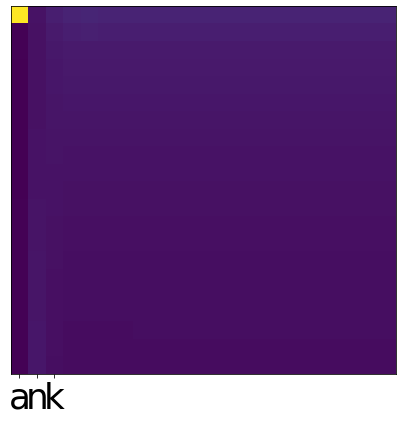

In [55]:
plot_heatmaps(test_data_path, encoder_model, decoder_model, batch_size, input_token_index, target_token_index)